<a href="https://colab.research.google.com/github/HoseinNekouei/Twitter-Financial-News-Sentiment/blob/main/Tweet_Financial_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import transformers
transformers_version = transformers.__version__

if transformers_version > '4.31.0':
  !pip uninstall transformers
  !pip install transformers==4.31
else:
  print("transformers version:", transformers.__version__)

transformers version: 4.31.0


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the Data ###

In [4]:
import pandas as pd

# Load the CSV file in memory
train_path = '/content/drive/MyDrive/dataset/Accident_Tweet/train.csv'
test_path = '/content/drive/MyDrive/dataset/Accident_Tweet/test.csv'

train_df = pd.read_csv(train_path, usecols=['id', 'text', 'target'])
test_df = pd.read_csv(test_path, usecols=['id', 'text'])

Show example

In [5]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


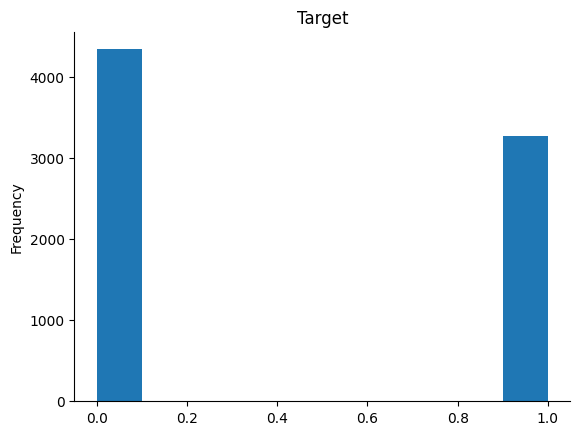

In [6]:
#import matplotlib library
from matplotlib import pyplot as plt

#Histogram of "Label" column in train datset
train_df['target'].plot(kind='hist', title='Target')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# Pritn theshape of datasets
print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (7613, 3)
test_df shape: (3263, 2)


### Removing the Special Characters ###

In [9]:

!pip install text_hammer

import text_hammer as th

def text_proccessing(df, col_name):
  """
  Process text data in a DataFrame column by performing the following operations:

  1. Convert text to lowercase.
  2. Remove emails from the text.
  3. Remove accented characters from the text.
  4. Remove URLs from the text.

  Parameters:
  df (DataFrame): Input DataFrame containing text data.
  col_name (str): Name of the column in the DataFrame containing text data.

  Returns:
  DataFrame: Processed DataFrame with text data after applying the specified operations.
  """

  df[col_name] = df[col_name].apply(lambda x:str(x).lower())
  df[col_name] = df[col_name].apply(lambda x: th.remove_emails(x))
  df[col_name] = df[col_name].apply(lambda x: th.remove_accented_chars(x))
  df[col_name] = df[col_name].apply(lambda x: th.remove_urls(x))

  return df

train_df = text_proccessing(train_df, 'text')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.38 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [10]:
# Print the first sample after cleaning data
train_df['text'].iloc[0:10]

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
5    #rockyfire update => california hwy. 20 closed...
6    #flood #disaster heavy rain causes flash flood...
7    i'm on top of the hill and i can see a fire in...
8    there's an emergency evacuation happening now ...
9    i'm afraid that the tornado is coming to our a...
Name: text, dtype: object

###Loading PreTrained BERT Model###

In [11]:
from transformers import AutoTokenizer, TFBertModel
tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [12]:
tokenizer(train_df['text'].iloc[0])

{'input_ids': [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
max_len = max([len(x.split()) for x in train_df.text])
print(f'Max len of tweets: {max_len}')

Max len of tweets: 31


In [14]:
x_train = tokenizer(
                text = train_df.text.tolist(),
                padding = True,
                max_length= 36,
                truncation= True,
                return_tensors = 'tf')

print(x_train)

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  1012, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [15]:
print(x_train['input_ids'].shape)
print(x_train['attention_mask'].shape)

(7613, 36)
(7613, 36)


In [16]:
print(train_df.target.value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


In [17]:
y_train = train_df.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

### Building the Model Architecture ###

In [24]:
from keras import layers, Model

max_length = 36

input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)

out = layers.Dropout(0.1)(embeddings)
out = layers.Dense(128, activation='relu')(out)
out = layers.Dropout(0.1)(out)
out = layers.Dense(32,activation = 'relu')(out)

y = layers.Dense(1,activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[1].trainable = True

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 36, 76                                     

In [26]:
from keras.optimizers import Adam

optimizer = Adam(
    learning_rate = 6e-06, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    weight_decay=0.01)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ["accuracy"])

In [ ]:
train_history = model.fit(
    x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_split = 0.1,
    epochs= 8,
    batch_size= 32)

Epoch 1/8
136/215 [=================>............] - ETA: 21s - loss: 0.3004 - accuracy: 0.9097

#### TESTING PHASE
on this phase we will make predictions out of our model

In [22]:
x_test = tokenizer(
    text = test_df.text.tolist(),
    padding= True,
    max_length= 36,
    truncation = True,
    return_tensors= 'tf')

In [23]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

102/102 [==============================] - 12s 93ms/step
